This notebook reproduce the results reported in the paper "Quantifying alarm fatigue caused by fault and defect detection systems" submited to CIRP Annals 2025.

### 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
pd.set_option('display.max_columns', 100)

In [3]:
import os
import sys
current_dir = os.getcwd()
root_dir = os.path.join(current_dir, "..")

src_dir = os.path.join(root_dir, "afm")
sys.path.append(src_dir)

from pca import PCA_fault_detection as acp
from utils import false_alarm_rate, fault_detection_rate, false_discovery_rate

### 2. Loading the data

In [4]:
fault_free_train = pd.read_csv(
    os.path.join(root_dir,"data/fault_free_training.csv")
)
fault_free_train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,1,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,80.044,51.435,2632.9,25.029,50.528,3101.1,22.819,65.732,229.61,341.22,94.640,77.047,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.83570,0.098577,53.724,43.828,62.881,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0,1,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,80.078,50.154,2633.8,24.419,48.772,3102.0,23.333,65.716,230.54,341.30,94.595,77.434,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.83570,0.098577,53.724,43.828,63.132,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0,1,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,80.220,50.302,2635.5,25.244,50.071,3103.5,21.924,65.732,230.08,341.38,94.605,77.466,31.767,8.7694,26.095,6.8259,18.961,1.6292,32.985,13.742,23.897,1.3001,18.765,2.2602,4.8543,2.3900,0.017866,0.83570,0.098577,53.724,43.828,63.117,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0,1,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,80.305,49.990,2635.6,23.268,50.435,3102.8,22.948,65.781,227.91,341.71,94.473,77.443,31.767,8.7694,26.095,6.8259,18.961,1.6292,32.985,13.742,23.897,1.3001,18.765,2.2602,4.8543,2.3900,0.017866,0.83570,0.098577,53.724,43.828,63.100,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0,1,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,80.064,51.310,2632.4,26.099,50.480,3103.5,22.808,65.788,231.37,341.11,94.678,76.947,32.322,8.5821,26.769,6.8688,18.782,1.6396,33.071,13.834,24.228,1.0938,18.666,2.2193,4.8304,2.2416,0.017866,0.83570,0.098577,53.724,43.828,63.313,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0,500,496,0.29325,3640.1,4473.0,9.1949,26.867,42.379,2700.2,75.533,120.41,0.34050,80.146,48.628,2628.4,24.419,51.045,3097.9,22.738,65.759,233.04,338.69,94.723,77.098,31.792,8.9538,25.746,6.9870,19.035,1.6084,32.348,14.030,23.705,1.2103,18.837,2.2941,4.9035,2.2539,0.026900,0.85987,0.091175,54.058,43.844,63.443,53.429,29.249,60.773,21.532,40.451,34.064,48.953,48.291,40.812,18.756
249996,0,500,497,0.29134,3625.7,4506.2,9.2109,26.889,42.291,2700.6,75.935,120.39,0.35374,80.350,51.544,2628.5,25.637,51.954,3098.7,22.464,65.830,231.85,338.98,94.768,77.602,32.226,8.8243,25.993,6.8963,19.259,1.6478,32.801,13.766,24.300,1.2646,18.669,2.2836,4.8441,2.2832,0.026900,0.85987,0.091175,54.058,43.844,62.542,53.830,28.975,61.517,21.750,42.762,42.645,51.055,48.589,40.933,19.360
249997,0,500,498,0.29438,3600.2,4478.3,9.1957,26.820,42.448,2700.3,74.706,120.41,0.35910,80.445,50.567,2628.7,25.430,50.102,3100.4,22.465,65.928,233.28,338.79,94.728,77.493,32.226,8.8243,25.993,6.8963,19.259,1.6478,32.801,13.766,24.300,1.2646,18.669,2.2836,4.8441,2.2832,0.026900,0.85987,0.091175,54.058,43.844,62.979,54.163,28.676,61.656,21.487,42.109,39.770,46.770,48.648,41.465,19.344
249998,0,500,499,0.25269,3683.5,4486.4,9.2832,27.188,42.757,2697.4,75.101,120.39,0.32469,80.332,51.418,2625.7,24.280,48.742,3098.2,22.815,65.984,233.67,338.46,94.721,77.418,32.150,9.0061,26.029,6.8643,18.985,1.6749,32.314,13.841,24.322,1.4914,18.907,2.267

In [5]:
fault_free_test = pd.read_csv(
    os.path.join(root_dir,"data/fault_free_testing.csv")
)
fault_free_test

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,1,1,0.25171,3672.4,4466.3,9.5122,27.057,42.473,2705.6,74.750,120.41,0.33642,80.185,50.671,2634.6,24.592,50.614,3102.5,24.119,65.764,231.94,341.27,94.660,77.137,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.83570,0.098577,53.724,43.828,62.908,54.494,24.527,59.710,22.357,40.149,40.074,47.955,47.300,42.100,15.345
1,0,1,2,0.25234,3642.2,4568.7,9.4145,26.999,42.586,2705.2,75.126,120.38,0.33801,80.104,49.508,2634.1,23.399,49.353,3102.3,23.817,65.729,229.67,341.76,94.558,77.130,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.83570,0.098577,53.724,43.828,63.429,53.269,24.465,60.466,22.413,39.956,36.651,45.038,47.502,40.553,16.063
2,0,1,3,0.24840,3643.1,4507.5,9.2901,26.927,42.278,2703.5,74.540,120.38,0.33702,79.988,51.280,2632.1,24.319,49.144,3100.7,21.973,65.708,229.94,341.47,94.732,77.168,32.492,8.9860,25.882,6.9881,18.750,1.6203,33.387,13.666,23.703,1.2234,18.834,2.2782,4.8584,2.3201,0.017866,0.83570,0.098577,53.724,43.828,63.412,54.000,24.860,60.642,22.199,40.074,41.868,44.553,47.479,41.341,20.452
3,0,1,4,0.25153,3628.3,4519.3,9.3347,26.999,42.330,2703.9,74.861,120.38,0.33648,79.957,50.668,2632.3,24.209,50.654,3101.3,23.378,65.692,230.42,341.38,94.466,77.147,32.492,8.9860,25.882,6.9881,18.750,1.6203,33.387,13.666,23.703,1.2234,18.834,2.2782,4.8584,2.3201,0.017866,0.83570,0.098577,53.724,43.828,63.668,53.860,24.553,61.908,21.981,40.141,40.066,48.048,47.440,40.780,17.123
4,0,1,5,0.21763,3655.8,4571.0,9.3087,26.901,42.402,2707.7,74.380,120.40,0.32114,80.261,50.066,2636.1,25.682,49.198,3102.2,22.692,65.723,229.42,341.53,94.770,77.868,32.396,8.9172,26.103,6.6982,18.333,1.6463,32.913,13.874,23.524,1.2179,18.527,2.2895,4.8113,2.2049,0.017866,0.83570,0.098577,53.724,43.828,62.213,53.307,21.775,61.891,22.412,37.696,38.295,44.678,47.530,41.089,18.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,0,500,956,0.26428,3671.5,4510.8,9.2852,27.141,42.297,2699.9,74.296,120.41,0.33822,80.353,49.535,2628.9,25.585,51.547,3097.8,22.643,66.486,249.99,341.56,94.494,77.239,32.328,8.6921,25.985,7.0899,18.827,1.6506,33.646,13.844,23.509,1.0825,18.787,2.2994,4.8223,2.3555,0.026771,0.85282,0.098058,53.863,43.666,64.082,53.942,26.022,61.709,22.417,40.510,36.731,50.115,52.721,40.927,18.854
479996,0,500,957,0.25132,3573.4,4483.9,9.2872,26.604,42.311,2698.1,74.629,120.40,0.33728,80.155,48.653,2626.6,24.854,50.510,3094.7,22.641,66.543,250.45,341.68,94.698,77.390,32.355,8.8373,26.515,6.8426,19.004,1.6293,33.515,13.815,23.419,1.1804,18.424,2.2789,4.8595,2.2484,0.026771,0.85282,0.098058,53.863,43.666,62.646,53.760,24.585,61.267,21.928,39.893,34.136,47.714,52.908,41.412,18.847
479997,0,500,958,0.25105,3622.6,4433.3,9.3998,26.707,41.936,2699.5,75.484,120.38,0.33560,80.131,49.145,2628.4,23.213,50.738,3095.1,23.518,66.534,250.88,341.81,94.822,77.171,32.355,8.8373,26.515,6.8426,19.004,1.6293,33.515,13.815,23.419,1.1804,18.424,2.2789,4.8595,2.2484,0.026771,0.85282,0.098058,53.863,43.666,61.800,54.366,24.613,61.745,22.212,40.098,35.585,48.241,53.099,40.150,16.791
479998,0,500,959,0.24521,3660.5,4485.2,9.3885,26.936,42.639,2700.5,74.614,120.39,0.33390,80.080,49.154,2629.0,25.003,49.983,3096.6,23.382,66.524,252.79,341.95,94.722,77.451,32.592,8.8641,26.346,6.9779,18.282,1.6286,33.441,13.667,23.340,1.3458,18.825,2.313

In [6]:
faulty_test = pd.read_csv(
    os.path.join(root_dir,"data/faulty_testing.csv")
)
faulty_test

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1,1,1,0.25171,3672.4,4466.3,9.5122,27.057,42.473,2705.6,74.750,120.41,0.33642,80.185,50.671,2634.6,24.592,50.614,3102.5,24.119,65.764,231.94,341.27,94.660,77.137,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.83570,0.098577,53.724,43.828,62.908,54.494,24.527,59.710,22.357,40.149,40.074,47.955,47.300,42.100,15.345
1,1,1,2,0.25234,3642.2,4568.7,9.4145,26.999,42.586,2705.2,75.126,120.38,0.33801,80.104,49.508,2634.1,23.399,49.353,3102.3,23.817,65.729,229.67,341.76,94.558,77.130,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.83570,0.098577,53.724,43.828,63.429,53.269,24.465,60.466,22.413,39.956,36.651,45.038,47.502,40.553,16.063
2,1,1,3,0.24840,3643.1,4507.5,9.2901,26.927,42.278,2703.5,74.540,120.38,0.33702,79.988,51.280,2632.1,24.319,49.144,3100.7,21.973,65.708,229.94,341.47,94.732,77.168,32.492,8.9860,25.882,6.9881,18.750,1.6203,33.387,13.666,23.703,1.2234,18.834,2.2782,4.8584,2.3201,0.017866,0.83570,0.098577,53.724,43.828,63.412,54.000,24.860,60.642,22.199,40.074,41.868,44.553,47.479,41.341,20.452
3,1,1,4,0.25153,3628.3,4519.3,9.3347,26.999,42.330,2703.9,74.861,120.38,0.33648,79.957,50.668,2632.3,24.209,50.654,3101.3,23.378,65.692,230.42,341.38,94.466,77.147,32.492,8.9860,25.882,6.9881,18.750,1.6203,33.387,13.666,23.703,1.2234,18.834,2.2782,4.8584,2.3201,0.017866,0.83570,0.098577,53.724,43.828,63.668,53.860,24.553,61.908,21.981,40.141,40.066,48.048,47.440,40.780,17.123
4,1,1,5,0.21763,3655.8,4571.0,9.3087,26.901,42.402,2707.7,74.380,120.40,0.32114,80.261,50.066,2636.1,25.682,49.198,3102.2,22.692,65.723,229.42,341.53,94.770,77.868,32.396,8.9172,26.103,6.6982,18.333,1.6463,32.913,13.874,23.524,1.2179,18.527,2.2895,4.8113,2.2049,0.017866,0.83570,0.098577,53.724,43.828,62.213,53.307,21.775,61.891,22.412,37.696,38.295,44.678,47.530,41.089,18.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,20,1,956,0.27389,3638.5,4512.7,9.3480,26.764,42.231,2713.2,74.348,120.43,0.31466,80.052,50.609,2633.2,25.664,50.994,3107.5,23.561,65.794,240.68,341.09,94.422,77.657,32.339,8.8519,26.379,6.9198,18.628,1.6707,33.313,13.672,23.542,1.3807,18.803,2.2588,4.8415,2.3543,0.013134,0.83818,0.106060,53.699,43.657,63.395,54.051,26.807,63.206,21.214,36.950,39.891,48.834,49.969,42.244,16.814
19196,20,1,957,0.25405,3656.7,4490.2,9.3897,27.067,42.065,2715.9,74.945,120.40,0.31525,80.242,51.178,2636.0,25.242,51.585,3110.4,23.153,65.928,241.29,341.22,94.514,77.383,32.656,9.0246,26.776,6.7805,18.874,1.6360,32.999,13.780,23.861,1.4064,18.487,2.3016,4.7892,2.2556,0.013134,0.83818,0.106060,53.699,43.657,62.391,54.334,25.185,61.865,21.657,37.441,41.566,50.203,50.270,41.264,17.765
19197,20,1,958,0.25664,3645.5,4506.3,9.4222,26.647,42.139,2715.5,74.313,120.41,0.31779,79.957,49.464,2633.4,23.085,48.435,3110.2,22.063,65.989,242.73,341.79,94.457,77.089,32.656,9.0246,26.776,6.7805,18.874,1.6360,32.999,13.780,23.861,1.4064,18.487,2.3016,4.7892,2.2556,0.013134,0.83818,0.106060,53.699,43.657,62.584,54.141,24.931,63.582,20.960,37.131,36.523,42.912,50.497,41.720,20.372
19198,20,1,959,0.21993,3686.1,4507.0,9.3934,26.625,42.214,2710.9,74.022,120.40,0.32622,79.437,51.634,2627.5,24.762,50.224,3106.7,22.192,65.941,243.66,341.41,94.603,76.113,31.847,9.0665,26.351,6.8587,18.564,1.7230,32.823,13.787,23.949,1.3248,18.936,2.2807,4.8882

### 3. Training the detection model

Before training the detection model, we will first select the number of principal components by using the parallel analysis method. Two detection threshold are considered. The first one is associated with a nominal risk of 1% of false alarm whereas the second one is associated with a nominal risk of 5% of false alarm. 

In [7]:
variables = fault_free_train.columns
sensors = variables[3:]
len(sensors)

52

In [8]:
X_train = fault_free_train[sensors]


In [13]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
model_pa = PCA(X_train_sc.shape[1]-1)
transformedData = model_pa.fit_transform(X_train_sc)

In [10]:
random_eigenvalues = np.zeros(X_train_sc.shape[1]-1)
for i in tqdm(range(100)):
    random_data = pd.DataFrame(np.random.normal(0, 1, [X_train_sc.shape[1]-1, X_train_sc.shape[0]]))
    pca_random = PCA(X_train_sc.shape[1]-1)
    pca_random.fit(random_data)
    transformedRandomData = pca_random.transform(random_data)
    random_eigenvalues = random_eigenvalues+pca_random.explained_variance_ratio_
random_eigenvalues = random_eigenvalues / 100

100%|██████████| 100/100 [09:46<00:00,  5.87s/it]


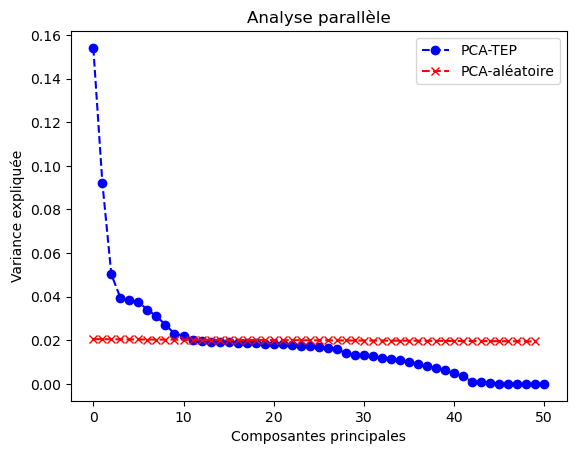

In [15]:
plt.plot(model_pa.explained_variance_ratio_, '--bo', label='PCA-TEP')
plt.plot(random_eigenvalues[:-1], '--rx', label='PCA-Random_data')
plt.xlabel('Principal components')
plt.ylabel('Explained variance')
plt.legend()
plt.title('Parallel analysis')
plt.show()

Twelve pricipal components are selected for the model

We will consider two detection threshold

12

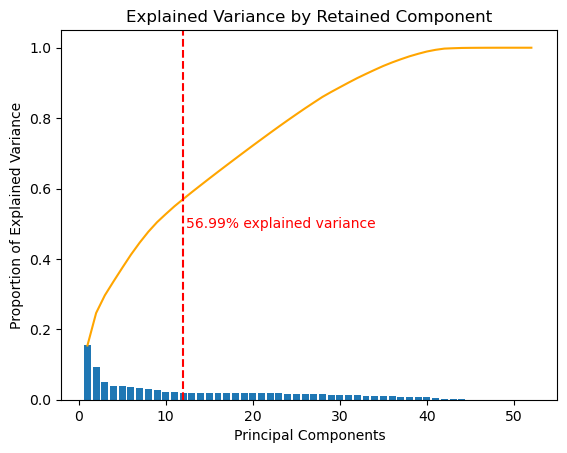

In [ ]:
model = acp(n_component=12)
model.fit(X_train,alpha=0.01)

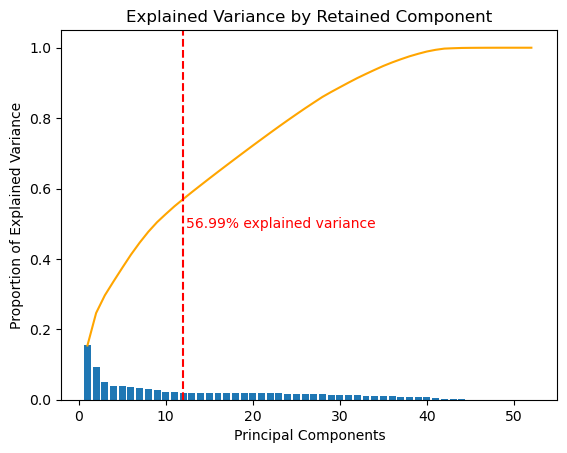

In [22]:
model_bis = acp(n_component=12)
model_bis.fit(X_train,alpha=0.05)

### 4. Evaluation of the detection models

#### 4.1 Model with a nominal risk of 1% of false alarm

In [16]:
fault_free_test_spe = model.calculate_spe(fault_free_test[sensors])
false_positive,false_positive_rate=false_alarm_rate(fault_free_test_spe,model.Q_lim)

Number of samples :  480000
Number of false positive :  4524
Percentage of false positive :0.94%


In [19]:
for fault in range(1,21):
    if fault in [3, 9, 15]:
        continue
    faulty = faulty_test[(faulty_test['faultNumber']==fault)&(faulty_test['sample']>160)]
    faulty_spe = model.calculate_spe(faulty[sensors])
    print(f'Fault Number = {fault}\n-----------------------')
    print('Threshold with a nominal risk of 1% of false alarm')
    fault_detection_rate(faulty_spe,model.Q_lim)

Fault Number = 1
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples :  797
Percentage of detected faulty_samples :99.62%
Fault Number = 2
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples :  789
Percentage of detected faulty_samples :98.62%
Fault Number = 4
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples :  792
Percentage of detected faulty_samples :99.0%
Fault Number = 5
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples :  92
Percentage of detected faulty_samples :11.5%
Fault Number = 6
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples :

In [18]:
detection_rate = []
total_detected_fault = 0
for fault in range(1,21):
    if fault in [3, 9, 15]:
        continue
    faulty = faulty_test[(faulty_test['faultNumber']==fault)&(faulty_test['sample']>160)]
    faulty_spe = model.calculate_spe(faulty[sensors])
    detected_fault,f_detection_r= fault_detection_rate(faulty_spe,model.Q_lim)
    detection_rate.append([f"Fault {fault}", f_detection_r])
    total_detected_fault += detected_fault
results = pd.DataFrame(detection_rate, columns=["Fault", "Fault_detection_rate(%)"])

Number of faulty samples :  800
Number of detected faulty samples :  797
Percentage of detected faulty_samples :99.62%
Number of faulty samples :  800
Number of detected faulty samples :  789
Percentage of detected faulty_samples :98.62%
Number of faulty samples :  800
Number of detected faulty samples :  792
Percentage of detected faulty_samples :99.0%
Number of faulty samples :  800
Number of detected faulty samples :  92
Percentage of detected faulty_samples :11.5%
Number of faulty samples :  800
Number of detected faulty samples :  800
Percentage of detected faulty_samples :100.0%
Number of faulty samples :  800
Number of detected faulty samples :  799
Percentage of detected faulty_samples :99.88%
Number of faulty samples :  800
Number of detected faulty samples :  775
Percentage of detected faulty_samples :96.88%
Number of faulty samples :  800
Number of detected faulty samples :  67
Percentage of detected faulty_samples :8.38%
Number of faulty samples :  800
Number of detected fa

In [20]:
results

,Fault,Fault_detection_rate(%)
0,Fault 1,99.62
1,Fault 2,98.62
2,Fault 4,99.00
3,Fault 5,11.50
4,Fault 6,100.00
5,Fault 7,99.88
6,Fault 8,96.88
7,Fault 10,8.38
8,Fault 11,60.75
9,Fault 12,96.38


In [21]:
false_discovery_rate(n_false_positive=false_positive,n_detected_fault=total_detected_fault)

pourcentage de fausses decouvertes :31.94%


#### 4.2 Model with a nominal risk of 5% of false alarm

In [23]:
fault_free_test_spe_bis = model_bis.calculate_spe(fault_free_test[sensors])
false_positive_bis,false_positive_rate_bis=false_alarm_rate(fault_free_test_spe,model_bis.Q_lim)

Number of samples :  480000
Number of false positive :  23822
Percentage of false positive :4.96%


In [24]:
for fault in range(1,21):
    if fault in [3, 9, 15]:
        continue
    faulty = faulty_test[(faulty_test['faultNumber']==fault)&(faulty_test['sample']>160)]
    faulty_spe_bis = model_bis.calculate_spe(faulty[sensors])
    print(f'Fault Number = {fault}\n-----------------------')
    print('Threshold with a nominal risk of 1% of false alarm')
    fault_detection_rate(faulty_spe_bis,model_bis.Q_lim)

Fault Number = 1
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples :  797
Percentage of detected faulty_samples :99.62%
Fault Number = 2
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples :  793
Percentage of detected faulty_samples :99.12%
Fault Number = 4
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples :  799
Percentage of detected faulty_samples :99.88%
Fault Number = 5
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples :  188
Percentage of detected faulty_samples :23.5%
Fault Number = 6
-----------------------
Threshold with a nominal risk of 1% of false alarm
Number of faulty samples :  800
Number of detected faulty samples

In [25]:
detection_rate_bis = []
total_detected_fault_bis = 0
for fault in range(1,21):
    if fault in [3, 9, 15]:
        continue
    faulty = faulty_test[(faulty_test['faultNumber']==fault)&(faulty_test['sample']>160)]
    faulty_spe_bis = model_bis.calculate_spe(faulty[sensors])
    detected_fault_bis,f_detection_r_bis= fault_detection_rate(faulty_spe_bis,model_bis.Q_lim)
    detection_rate_bis.append([f"Fault {fault}", f_detection_r_bis])
    total_detected_fault_bis += detected_fault_bis
results_bis = pd.DataFrame(detection_rate_bis, columns=["Fault", "Fault_detection_rate(%)"])

Number of faulty samples :  800
Number of detected faulty samples :  797
Percentage of detected faulty_samples :99.62%
Number of faulty samples :  800
Number of detected faulty samples :  793
Percentage of detected faulty_samples :99.12%
Number of faulty samples :  800
Number of detected faulty samples :  799
Percentage of detected faulty_samples :99.88%
Number of faulty samples :  800
Number of detected faulty samples :  188
Percentage of detected faulty_samples :23.5%
Number of faulty samples :  800
Number of detected faulty samples :  800
Percentage of detected faulty_samples :100.0%
Number of faulty samples :  800
Number of detected faulty samples :  800
Percentage of detected faulty_samples :100.0%
Number of faulty samples :  800
Number of detected faulty samples :  778
Percentage of detected faulty_samples :97.25%
Number of faulty samples :  800
Number of detected faulty samples :  180
Percentage of detected faulty_samples :22.5%
Number of faulty samples :  800
Number of detected

In [26]:
results_bis

,Fault,Fault_detection_rate(%)
0,Fault 1,99.62
1,Fault 2,99.12
2,Fault 4,99.88
3,Fault 5,23.50
4,Fault 6,100.00
5,Fault 7,100.00
6,Fault 8,97.25
7,Fault 10,22.50
8,Fault 11,71.50
9,Fault 12,97.75


In [27]:
false_discovery_rate(n_false_positive=false_positive_bis,n_detected_fault=total_detected_fault_bis)

pourcentage de fausses decouvertes :69.64%
